# Lab 4 - Comparison of Binary Classifiers

The seeds dataset will be used in this example. All columns are numerical, the `type` column has 3 values of wheat variety, one of which will be used as `class` 1 for predictions. 

We will train a binary classification model for this, there is less restriction on the specific classifications that are preffered to be misspecified or correctly specified. Thus, we aim for high precision for class 1. 

The `class` column is the dependent variable (y), while the others are the predictors (X).

Training involved splitting the data into test and train sets, and further splitting the train set multiple times for cross-valiadation for fine tuning of parameters. The classifiers; SVM, Random Forest, and KNN are explored and compared. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support, precision_recall_curve
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## EDA - Exploratory Data Analysis

In [2]:
df = pd.read_csv("./seeds.csv")
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [3]:
df.tail()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3
209,12.30,13.34,0.8684,5.243,2.974,5.637,5.063,3


In [4]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

In [5]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

There are no missing values. We will use boxlpots of these columns to check for outliers. 

In [6]:
df.describe()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


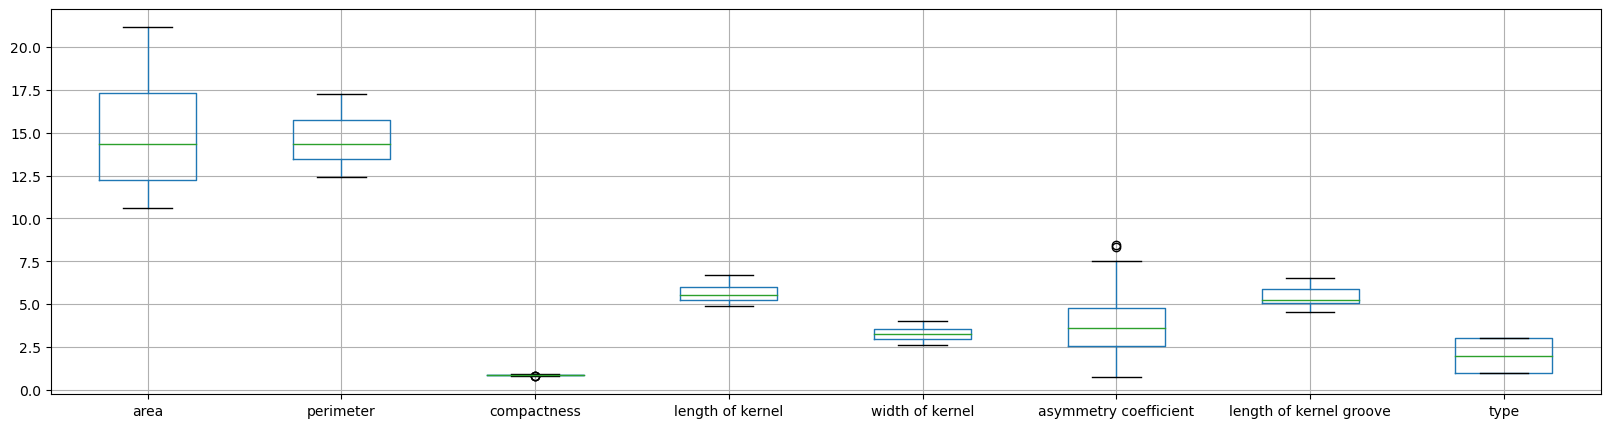

In [7]:
df.boxplot(figsize=(20,5))
plt.show()

There are outliers only for `asymmetry coefficient` and`compactness` so the robust scaler will be applied to them. Also, it is apparent that the variables are on different scales. The median values of `area` and `perimeter` are much larger than those of the others, most notably `compactness`. Histograms of the variables should help our analysis. 

array([[<Axes: title={'center': 'area'}>,
        <Axes: title={'center': 'perimeter'}>,
        <Axes: title={'center': 'compactness'}>],
       [<Axes: title={'center': 'length of kernel'}>,
        <Axes: title={'center': 'width of kernel'}>,
        <Axes: title={'center': 'asymmetry coefficient'}>],
       [<Axes: title={'center': 'length of kernel groove'}>,
        <Axes: title={'center': 'type'}>, <Axes: >]], dtype=object)

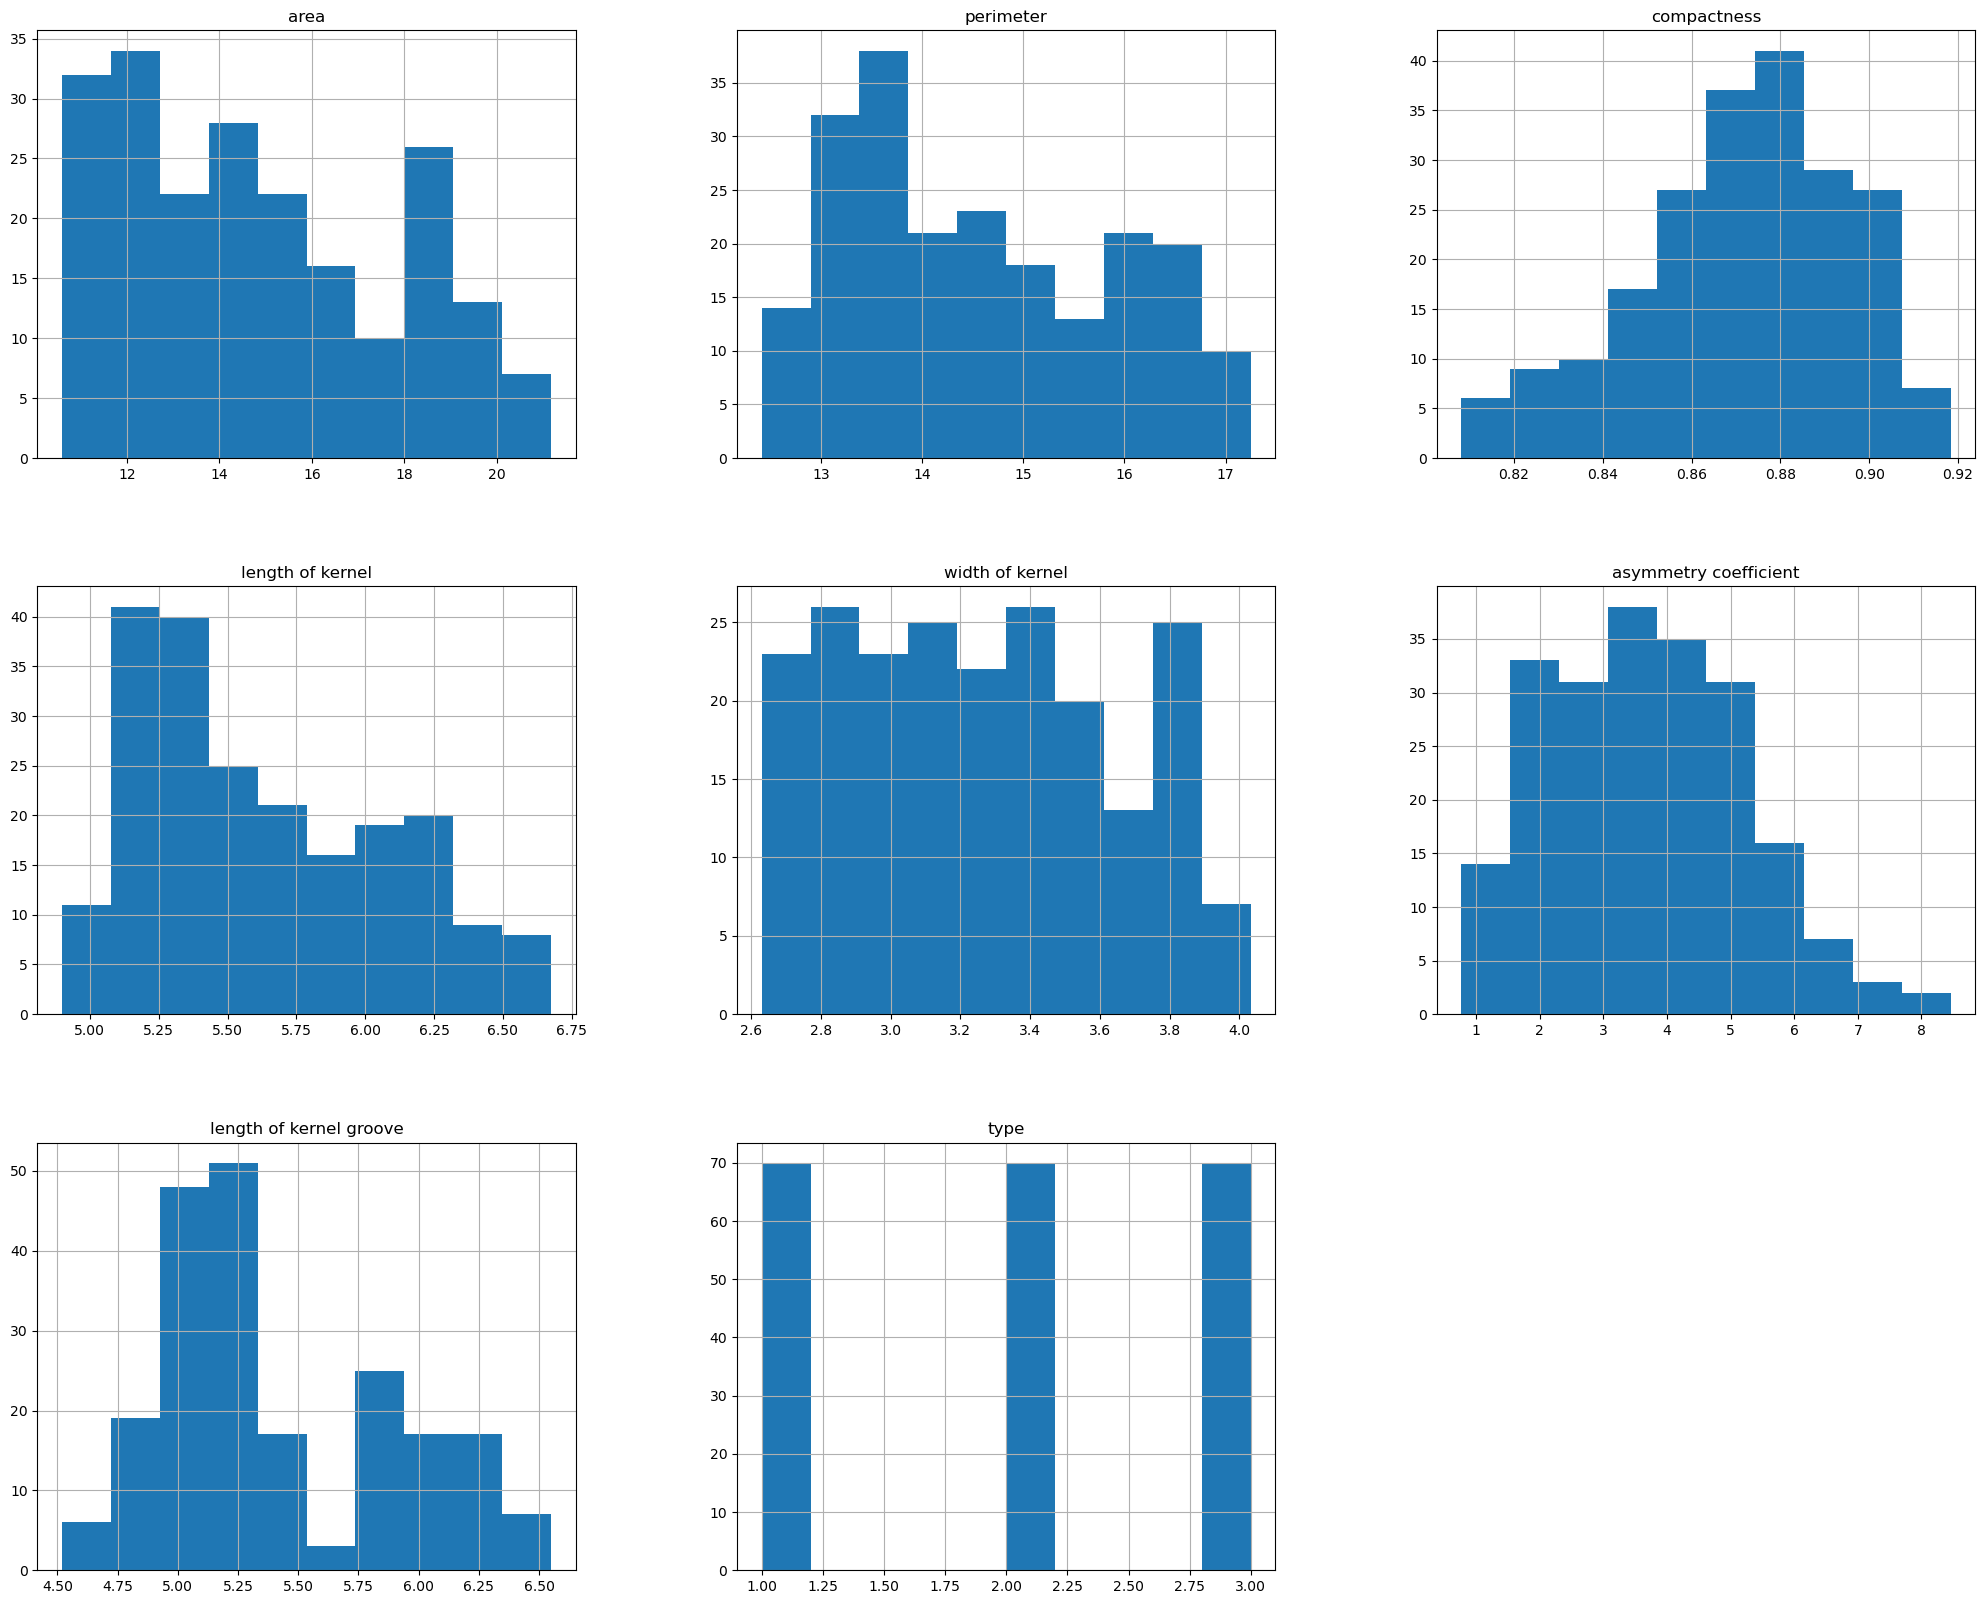

In [8]:
df.hist(bins=10, figsize=(25, 20))

It appears that `area`, `compactness` and `length of kernel` are most right skewed, while `width of kernel` follows no apparent normal distribution. None of the attributes contain 0, so we can use log transformation. 

## Data Preparation

We will transform the `type` column to `class` containing two values, 0 and 1. 

In [9]:
mapper = {1: 0, 2: 1, 3:1}
df['class'] = df['type'].replace(mapper)
df = df.drop(['type'], axis=1)
df['class'].value_counts()

1    140
0     70
Name: class, dtype: int64

Next we split the columns into a target *`y`* and predictors *`X`*.

In [10]:
y = df['class']
X = df.drop('class', axis=1)

First we will train and evaluate the SVM and Random Forest classifiers, followed by training the KNN classifier, and comparing it to all models. We will apply hypertuning of parameters, compare them and choose the best approach to the data. This approach will involve a skcikit-learn pipeline to preprocess the data applied later. The pipeline will ensure that the training validation and test data is processed seperately without leakage. 

We first group the columns based on the presence of outliers.  

In [11]:
# grouping the clolumns with outliers.
columns_outliers = ['asymmetry coefficient', 'compactness'];

In [12]:
# grouping the columns with no outliers. 
columns_no_outliers = [item for item in list(X.columns) 
                             if item not in columns_outliers]

# verify the correct columns are selected
print(columns_no_outliers)
print(columns_outliers)
print(len(columns_no_outliers))
print(len(columns_outliers))

['area', 'perimeter', 'length of kernel', 'width of kernel', 'length of kernel groove']
['asymmetry coefficient', 'compactness']
5
2


Using the Pipeline and ColumnTransformer we build a preprocessing pipeline. 

In [13]:
outliers_pipeline = Pipeline(
    steps = [
        ("log_transform", FunctionTransformer(np.log)), 
        ("scaler", RobustScaler())
    ]
)

preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("outliers", outliers_pipeline, columns_outliers),    
        ("no_outliers", FunctionTransformer(np.log), columns_no_outliers)
    ],
    remainder="passthrough" # note there are no remaining columns in this example
)

We can now create test and train datasets using 20% testing data. 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

Stratify=y ensures an equal proportion of classes in each strata of data. 

## Model Training

### SVM (TASK 2)

We create a pipeline including the preprocessing pipeline and SVM classifier. The pipeline ensures no data leakage by seperately preprocessing the training and validation sets after further splitting the training and validation sets in the process for cross-validation. 

In [15]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

In [16]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('outliers',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['asymmetry coefficient',
                                                   'compactness']),
                                                 ('no_outliers',
                                                  FunctionTransformer(func=<ufunc 'log'>),
                                                  ['area', 'perimeter',
                                                   'length of kernel',
                                                   'width of kernel',
                                                   'length of kernel '
                                                   'groove'])])),
                ('svm', SVC(probability=True))])

We train the SVM model by exploring the combinations of values of parameters of the predictor (SVM). 

In [17]:
# param__grid contains the parameters of the SVM model, it is a non exhaustive list

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# the best SVM and parameters are stored 
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.917:
Best parameters:  {'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'linear'}


Using refit=True, the SVM is refitted on the whole training set afer the best parameters are determined. 

### Random Forest (TASK 2)

In [18]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

In [19]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('outliers',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['asymmetry coefficient',
                                                   'compactness']),
                                                 ('no_outliers',
                                                  FunctionTransformer(func=<ufunc 'log'>),
                                                  ['area', 'perimeter',
                                                   'length of kernel',
                                                   'width of kernel',
                                                   'length of kernel '
                                                   'groove'])])),
                ('rf', RandomForestClassifier())])

In [20]:
# param grid contains a non exhaustive 
# list of the parameters of the Random Forest classifier. 

param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.946:
Best parameters:  {'rf__max_depth': 8, 'rf__n_estimators': 20}


## Compare Classifiers on Test Set (TASK 2)

Using the function from the lab example, we will output the following metrics for each classifier:

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

These metrics will be used to calculate the FPR for the ROC curves, and the precision-recall curve which is preferred in this case of imbalanced data. 

The same FPR rate must be used for all ROC curves, thus we create an incremented list from 0,1 with 100 equally spaced values. 

In [21]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [22]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [23]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

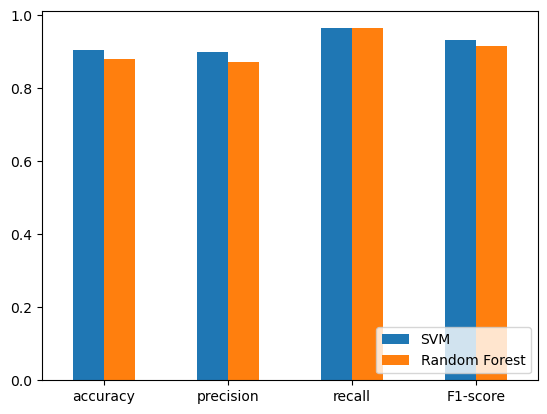

In [24]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

The SVM outperforms the RF across all metrics except for recall (the clasifiers preform equally when identifying true positives). Results of this analysis will vary depending on the version of this notebook. 

Below, the ROC curve for the two classifiers is plotted. 

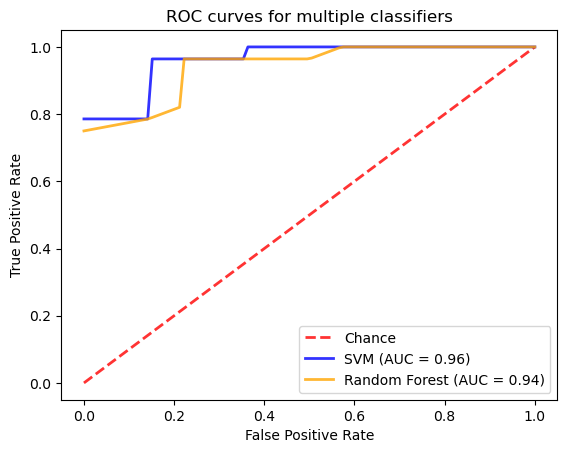

In [36]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

The ROC curve shows that each classifier outperforms the guess by chance (red). The SVM clearly has the greatest area under the curve (1) signifying high proportion of correct predictions. 

Since the data has an imbalance (33% of observations are in class 1) we will use the preffered precision-recall curve to compare the models. 

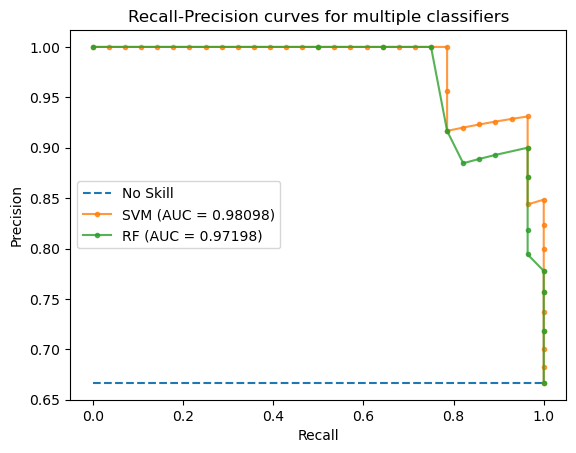

In [47]:
SVM_predicted_prob = SVM_best_model.predict_proba(X_test)[:, 1]
RF_predicted_prob = RF_best_model.predict_proba(X_test)[:, 1]   
SVM_precision_plt, SVM_recall_plt, _ = precision_recall_curve(y_test, SVM_predicted_prob)
RF_precision_plt, RF_recall_plt, _ = precision_recall_curve(y_test, RF_predicted_prob)

# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(SVM_recall_plt, SVM_precision_plt, marker='.', label='SVM (AUC = %0.5f)' % (auc(SVM_recall_plt, SVM_precision_plt)), alpha=0.8)
plt.plot(RF_recall_plt, RF_precision_plt, marker='.', label='RF (AUC = %0.5f)' % (auc(RF_recall_plt, RF_precision_plt)), alpha=0.8)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.title('Recall-Precision curves for multiple classifiers')
plt.legend()
# show the plot
plt.show()

The precision recall curve aligns with our previous results, the SVM approach results in the highest precision and recall for all thresholds. 

### KNearest Neighbours (TASK 3)

In [37]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('KNN', KNeighborsClassifier())])

In [38]:
set_config(display="diagram")
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('outliers',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<ufunc 'log'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['asymmetry coefficient',
                                                   'compactness']),
                                                 ('no_outliers',
                                                  FunctionTransformer(func=<ufunc 'log'>),
                                                  ['area', 'perimeter',
                                                   'length of kernel',
                                                   'width of kernel',
                                                   'length of kernel '
                                                   'groove'])])),
                ('KNN', KNeighborsClassifier())])

In [39]:
# param grid contains a non-exhaustive list of KNN parameters for hypertuning. 
param_grid = {
    'KNN__n_neighbors': [2, 3, 5],
    'KNN__weights': ['uniform', 'distance']
    
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.869:
Best parameters:  {'KNN__n_neighbors': 3, 'KNN__weights': 'distance'}


## Comparison of Classifiers on Test Set (TASK 3)

We now compare the KNN classifier with the SVM and RF classifiers from TASK 2. 

In [42]:
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, KNN_best_model)

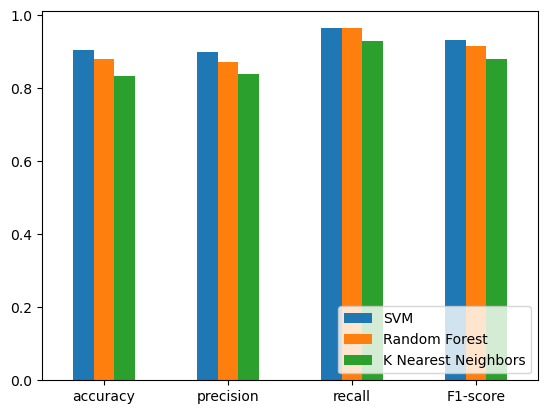

In [43]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'K Nearest Neighbors': KNN_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

The SVM is the best perforimg classifier across most metrics. Clearly, the SVM outperforms the Random forest across all but the recall rate, as previously discusses. The Random Forest outperforms the KNN classifier across all metrics. We proceed to analyse the ROC curve of the three classifiers for class 1. 

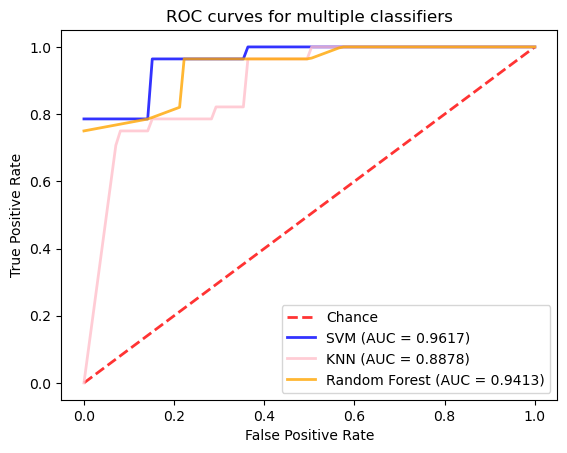

In [44]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.4f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr[0,:], lw=2, color='pink', label='KNN (AUC = %0.4f)' % (KNN_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.4f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

All three models perform better than classification by random chance, the Random Forest model has the best ROC curve of all, followed by the SVM and KNN classifiers. 
We can see the Area under the curve of the SVM is highest, and closest to 1, signifying very high false and true positive rates. 
Thus we select the random forest model as the best classifier. 

As before, we will use the precision recall curve rather than the ROC curve for our analysis. 
It is recommended to use the precision recall curve when the size of the classes are not equal, (https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/). 

Thus, we examine such curves for the best KNN, SVM, and RF models. 

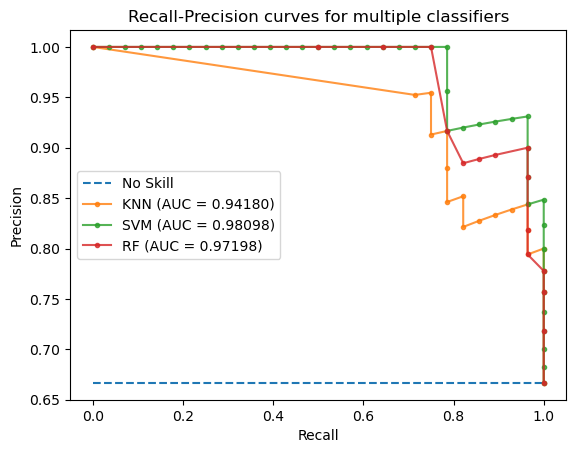

In [46]:
KNN_predicted_prob = KNN_best_model.predict_proba(X_test)[:, 1]
KNN_precision_plt, KNN_recall_plt, _ = precision_recall_curve(y_test, KNN_predicted_prob)


no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(KNN_recall_plt, KNN_precision_plt, marker='.', label='KNN (AUC = %0.5f)' % (auc(KNN_recall_plt, KNN_precision_plt)), alpha=0.8)
plt.plot(SVM_recall_plt, SVM_precision_plt, marker='.', label='SVM (AUC = %0.5f)' % (auc(SVM_recall_plt, SVM_precision_plt)), alpha=0.8)
plt.plot(RF_recall_plt, RF_precision_plt, marker='.', label='RF (AUC = %0.5f)' % (auc(RF_recall_plt, RF_precision_plt)), alpha=0.8)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.title('Recall-Precision curves for multiple classifiers')
plt.legend()
# show the plot
plt.show()


The precision recall curve aligns with our previous results, the SVM approach results in the highest precision and recall rates for all thresholds suggesting high quality of positive prediction and a higher number of true positives. The curve of the SVM is slightly greater than the RF classifier, and much greater than the KNN classifier. 

## Train the Final Model (TASK 3)

Assuming the more data the better, we train the random forest on all data. 

In [48]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

And saving this to disk, 

In [49]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))